In [1]:
# %#matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json


In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:

from urllib.request import urlretrieve
import requests

In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


In [5]:

dataset = get_dataset("electricity_nips")

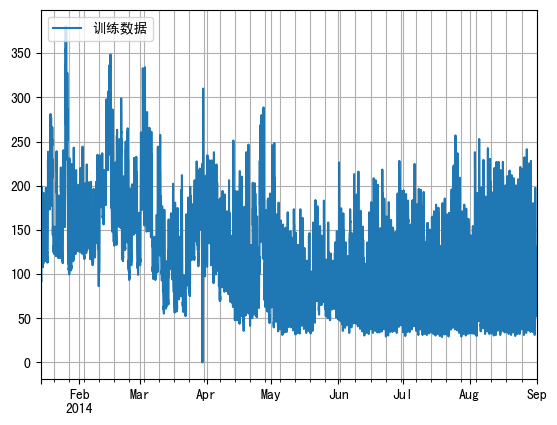

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["训练数据"], loc="upper left")
plt.show()

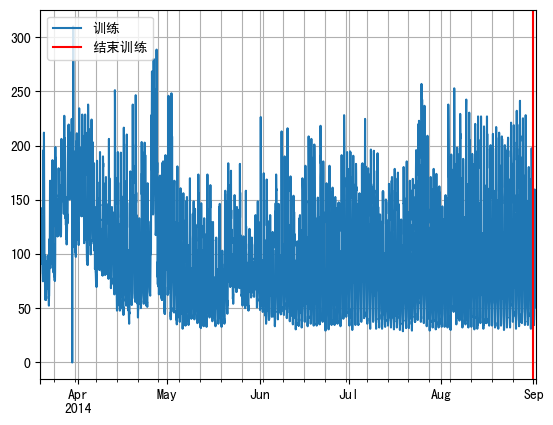

In [7]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # 结束数据集的训练
plt.grid(which="both")
plt.legend(["训练", "结束训练"], loc="upper left")
plt.show()

In [8]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: -1521
Recommended prediction horizon: 24
Frequency of the time series: H


In [9]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

In [11]:
from gluonts.dataset.common import ListDataset

In [12]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

In [13]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [14]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [15]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:10<00:00,  9.99it/s, epoch=5/5, avg_epoch_loss=4.58]


In [16]:
from gluonts.evaluation import make_evaluation_predictions

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [18]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [19]:
# first entry of the time series list
ts_entry = tss[0]

In [20]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([141.70506 , 141.12903 , 119.81567 , 139.40092 , 125.576035],
      dtype=float32)

In [21]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [22]:
# first 5 values
dataset_test_entry["target"][:5]

array([141.70506 , 141.12903 , 119.81567 , 139.40092 , 125.576035],
      dtype=float32)

In [23]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [24]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2014-09-01 01:00
Frequency of the time series: <Hour>


In [25]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 31.721037  34.542973  32.273457  29.21531   51.444653  38.17784
  62.037804 105.31351  170.26193  162.56175  141.60191  134.12184
 115.48386   97.85722  101.74987   83.984505  91.29708   90.10031
 103.16716  115.29228  103.523575  83.12283   57.945694  28.235605]
0.5-quantile (median) of the future window:
 [ 32.893764  34.936905  33.92943   29.637878  51.137024  37.68425
  61.576576 106.07846  177.2028   164.64604  141.69136  133.22575
 117.64907   98.03406  100.05934   83.49953   91.40744   88.68207
  99.30062  114.98983  106.38181   81.29287   58.383022  27.657578]


In [30]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["真实值", "区间中值"] + [
        f"{k}% 范围" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

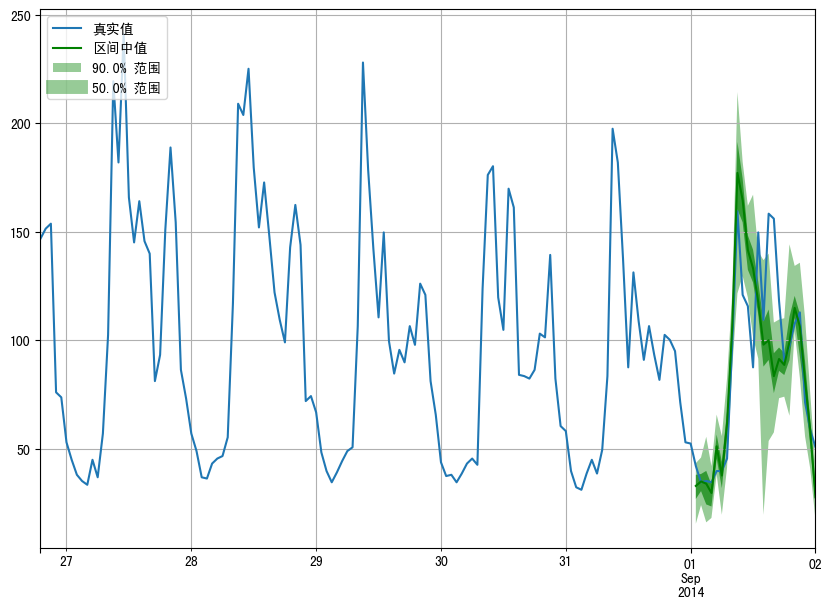

In [31]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [32]:
from gluonts.evaluation import Evaluator

In [33]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 2590it [00:00, 12334.40it/s]
/usr/local/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [34]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 261732.0341440686,
    "abs_error": 4303297.938516378,
    "abs_target_sum": 47042983.289749146,
    "abs_target_mean": 756.8047504785899,
    "seasonal_error": 49.5112981566798,
    "MASE": Infinity,
    "MAPE": 0.315420009060063,
    "sMAPE": 0.15437575235214934,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 2280034.3888975573,
    "Coverage[0.1]": 0.09528635778635777,
    "QuantileLoss[0.5]": 4303297.918818689,
    "Coverage[0.5]": 0.4921492921492922,
    "QuantileLoss[0.9]": 2200281.1415693657,
    "Coverage[0.9]": 0.9011261261261262,
    "RMSE": 511.5975314092794,
    "NRMSE": 0.6759967231782757,
    "ND": 0.0914758724380068,
    "wQuantileLoss[0.1]": 0.04846704501826069,
    "wQuantileLoss[0.5]": 0.09147587201928996,
    "wQuantileLoss[0.9]": 0.046771717856780054,
    "mean_absolute_QuantileLoss": 2927871.1497618705,
    "mean_wQuantileLoss": 0.06223821163144357,
    "MAE_Coverage": 0.40112612612612625,
    "OWA": NaN
}
